НИР Сегментация мыши. 

Для написания программы использовался язык прогаммирования Python.

Библиотеки: TenserFlow, OpenCV. Установлена CUDA и CuDNN для поддержки GPU от NVIDIA.

Модель для обучения: SegNet




In [1]:
import numpy as np
import cv2
import time
import math
import gc
import pandas as pd
import matplotlib.pyplot as plt
import os

In [2]:
import os
from glob import glob
# from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger, EarlyStopping
import matplotlib.pyplot as plt
from tqdm import tqdm
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger, EarlyStopping
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPool2D

In [3]:
from sklearn.utils import shuffle
from tensorflow.keras.optimizers.legacy import Nadam


In [ ]:
# ========== КОНФИГУРАЦИЯ ==========
GLOBAL_SHAPE_SIZE = 256
MODEL_NAME = "SegNet"
FILE_EXT = ".keras"
DATABASE_PATH = 'mouse_segmentation/'
SAVED_IMAGES_PATH = os.path.join(DATABASE_PATH, 'save_images')
LAST_VIDEO_IMAGES = 'videoImg'

os.makedirs(SAVED_IMAGES_PATH, exist_ok=True)

In [5]:
# ========== НАСТРОЙКА GPU И CUDA ==========
def setup_gpu():
    """Настройка GPU для использования CUDA"""
    # Проверяем доступные физические устройства
    gpus = tf.config.list_physical_devices('GPU')
    
    if gpus:
        try:
            # Разрешаем рост памяти GPU
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            
            # Логическая устройство должно быть создано после настройки GPU
            logical_gpus = tf.config.list_logical_devices('GPU')
            print(f"{len(gpus)} Physical GPU(s), {len(logical_gpus)} Logical GPU(s)")
            print(f"Using GPU: {gpus[0].name}")
            
            # Устанавливаем стратегию распределения
            strategy = tf.distribute.MirroredStrategy()
            print(f'Number of devices: {strategy.num_replicas_in_sync}')
            return strategy
            
        except RuntimeError as e:
            # Ошибка настройки GPU
            print(f"GPU setup error: {e}")
            print("Falling back to CPU")
            return None
    else:
        print("No GPU devices found. Using CPU")
        return None

In [6]:
class MaxUnpooling2D(layers.Layer):
    def __init__(self, pool_size=(2, 2), **kwargs):
        super(MaxUnpooling2D, self).__init__(**kwargs)
        self.pool_size = pool_size

    def call(self, inputs, output_shape):
        return tf.image.resize(inputs, output_shape[1:3], method='nearest')

    def get_config(self):
        config = super(MaxUnpooling2D, self).get_config()
        config.update({"pool_size": self.pool_size})
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)

In [7]:
def conv_block(inputs, filters, pool=True):
    x = Conv2D(filters, 3, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('ReLU')(x)
    x = Conv2D(filters, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('ReLU')(x)
    if pool:
        p = MaxPool2D((2, 2))(x)
        return x, p
    return x

In [8]:
def build_segnet(input_shape):
    tf.keras.backend.clear_session()
    inputs = Input(input_shape)

    # Encoder
    x1, p1 = conv_block(inputs, 64)
    x2, p2 = conv_block(p1, 128)
    x3, p3 = conv_block(p2, 256)
    x4, p4 = conv_block(p3, 512)

    # Bridge
    b = conv_block(p4, 512, pool=False)

    # Decoder
    d1 = MaxUnpooling2D((2, 2))(b, tf.shape(x4))
    d1 = conv_block(d1, 512, pool=False)
    d2 = MaxUnpooling2D((2, 2))(d1, tf.shape(x3))
    d2 = conv_block(d2, 256, pool=False)
    d3 = MaxUnpooling2D((2, 2))(d2, tf.shape(x2))
    d3 = conv_block(d3, 128, pool=False)
    d4 = MaxUnpooling2D((2, 2))(d3, tf.shape(x1))
    d4 = conv_block(d4, 64, pool=False)

    # Output
    outputs = Conv2D(1, 1, padding='same', activation='sigmoid')(d4)
    return Model(inputs, outputs, name=MODEL_NAME)


In [9]:
def load_data(batch_size):
    dataset_path = DATABASE_PATH
    train_images = sorted(glob(os.path.join(dataset_path, "images/*")))
    train_masks = sorted(glob(os.path.join(dataset_path, "masks/*")))
    test_images = sorted(glob(os.path.join(dataset_path, "test_images/*")))
    test_masks = sorted(glob(os.path.join(dataset_path, "test_masks/*")))

    lenTrain = len(train_images)
    lenTest = len(test_images)
    print(f"Train: {lenTrain} images, {len(train_masks)} masks | Test: {lenTest} images, {len(test_masks)} masks")

    countTrain = (lenTrain // batch_size) * batch_size
    countTest = (lenTest // batch_size) * batch_size
    print(f"Effective Train: {countTrain}, Test: {countTest}")

    train_x, train_y = shuffle(train_images[:countTrain], train_masks[:countTrain], random_state=42)
    test_x, test_y = shuffle(test_images[:countTest], test_masks[:countTest], random_state=42)
    return (train_x, train_y), (test_x, test_y)


In [10]:
def convert_to_gray_img(path):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError(f"Failed to load image: {path}")
    return img

In [11]:
def mod_img(x):
    x = cv2.resize(x, (GLOBAL_SHAPE_SIZE, GLOBAL_SHAPE_SIZE))
    x = x / 255.0
    return x.astype(np.float32)

In [12]:
def read_image(path):
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    if x is None:
        raise ValueError(f"Failed to load image: {path}")
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
    x = mod_img(x)
    return x

In [13]:
def read_mask(path):
    x = convert_to_gray_img(path)
    x = cv2.resize(x, (GLOBAL_SHAPE_SIZE, GLOBAL_SHAPE_SIZE))
    x = np.where(x > 128, 1.0, 0.0).astype(np.float32)
    return np.expand_dims(x, axis=-1)

In [14]:
def preprocess_model_images(image_path, mask_path):
    def f(image_path, mask_path):
        image_path = image_path.decode()
        mask_path = mask_path.decode()
        x = read_image(image_path)
        y = read_mask(mask_path)
        return x, y

    image, mask = tf.numpy_function(f, [image_path, mask_path], [tf.float32, tf.float32])
    image.set_shape([GLOBAL_SHAPE_SIZE, GLOBAL_SHAPE_SIZE, 3])
    mask.set_shape([GLOBAL_SHAPE_SIZE, GLOBAL_SHAPE_SIZE, 1])
    return image, mask

In [15]:
def tf_dataset(images, masks, batch=8):
    dataset = tf.data.Dataset.from_tensor_slices((images, masks))
    dataset = dataset.map(preprocess_model_images, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.cache()
    dataset = dataset.shuffle(buffer_size=1000)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

In [16]:
# ========== ОСНОВНЫЕ ФУНКЦИИ ==========

def train_model():
    batch_size = 16
    epochs = 20
    lr = 1e-4
    model_path = os.path.join(DATABASE_PATH, MODEL_NAME + FILE_EXT)
    csv_path = os.path.join(DATABASE_PATH, MODEL_NAME + "_data.csv")

    (train_x, train_y), (test_x, test_y) = load_data(batch_size)
    train_dataset = tf_dataset(train_x, train_y, batch=batch_size)  # Исправлено здесь
    valid_dataset = tf_dataset(test_x, test_y, batch=batch_size)    # Исправлено здесь

    input_shape = (GLOBAL_SHAPE_SIZE, GLOBAL_SHAPE_SIZE, 3)
    model = build_segnet(input_shape)

    model.compile(
        loss="binary_crossentropy",
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        metrics=[
            tf.keras.metrics.IoU(num_classes=2, target_class_ids=[1]),
            tf.keras.metrics.Recall(),
            tf.keras.metrics.Precision(),
            'accuracy'
        ]
    )

    callbacks = [
        ModelCheckpoint(model_path, monitor="val_loss", save_best_only=True, verbose=1),
        ReduceLROnPlateau(monitor="val_loss", patience=5, factor=0.1, verbose=1),
        CSVLogger(csv_path),
        EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True),
    ]

    train_steps = len(train_x) // batch_size
    valid_steps = len(test_x) // batch_size

    return model, epochs, train_steps, valid_steps, callbacks, train_dataset, valid_dataset

In [17]:
def fit_model(model, epochs, train_steps, valid_steps, callbacks, train_dataset, valid_dataset):
    model.fit(
        train_dataset,
        validation_data=valid_dataset,
        epochs=epochs,
        steps_per_epoch=train_steps,
        validation_steps=valid_steps,
        callbacks=callbacks
    )

In [18]:
def check_image(image_path):
    if os.path.isfile(image_path):
        test_images = [image_path]
    elif os.path.isdir(image_path):
        test_images = glob(os.path.join(image_path, "*"))
    else:
        test_images = glob(image_path)
        
    if not test_images:
        print(f"No images found at {image_path}")
        return

    model_path = os.path.join(DATABASE_PATH, MODEL_NAME + FILE_EXT)
    if not os.path.exists(model_path):
        print(f"Model not found at {model_path}")
        return

    model = tf.keras.models.load_model(model_path, custom_objects={'MaxUnpooling2D': MaxUnpooling2D})

    for path in tqdm(test_images, total=len(test_images)):
        original_image = cv2.imread(path, cv2.IMREAD_COLOR)
        if original_image is None:
            print(f"Failed to load image: {path}")
            continue
        h_orig, w_orig, _ = original_image.shape

        x = read_image(path)
        x = np.expand_dims(x, axis=0)
        pred_mask = model.predict(x, verbose=0)[0]

        pred_mask = np.concatenate([pred_mask] * 3, axis=2)
        pred_mask = (pred_mask > 0.5) * 255
        pred_mask = pred_mask.astype(np.uint8)

        blur = cv2.GaussianBlur(pred_mask, (13, 13), 0)
        _, thresh = cv2.threshold(blur, 100, 255, cv2.THRESH_BINARY)

        pred_mask = cv2.resize(thresh, (w_orig, h_orig), interpolation=cv2.INTER_NEAREST)
        original_image = cv2.resize(original_image, (w_orig, h_orig), interpolation=cv2.INTER_LINEAR)
        original_image = original_image.astype(np.uint8)

        print(f"Path: {path}")
        print(f"pred_mask shape: {pred_mask.shape}, type: {pred_mask.dtype}")
        print(f"original_image shape: {original_image.shape}, type: {original_image.dtype}")

        if pred_mask.shape != original_image.shape:
            print(f"Shape mismatch: pred_mask {pred_mask.shape}, original_image {original_image.shape}")
            continue
        if pred_mask.dtype != original_image.dtype:
            print(f"Type mismatch: pred_mask {pred_mask.dtype}, original_image {original_image.dtype}")
            continue

        alpha = 0.6
        try:
            output_image = cv2.addWeighted(pred_mask, alpha, original_image, 1 - alpha, 0)
        except Exception as e:
            print(f"Error in cv2.addWeighted for {path}: {e}")
            continue

        name = os.path.basename(path)
        cv2.imwrite(os.path.join(SAVED_IMAGES_PATH, name), output_image)

In [19]:
def convert_to_vid(video_name='miceSeg.avi', fps=30):
    path_to_video_images = os.path.join(DATABASE_PATH, LAST_VIDEO_IMAGES)
    if not os.path.exists(path_to_video_images):
        print("Run mask_video first")
        return

    images = sorted([img for img in os.listdir(path_to_video_images) if img.endswith((".jpg", ".jpeg", ".png"))])
    if not images:
        print("No images found")
        return

    frame = cv2.imread(os.path.join(path_to_video_images, images[0]))
    if frame is None:
        print("Failed to read first frame")
        return
        
    height, width, _ = frame.shape

    path_to_video = os.path.join(DATABASE_PATH, video_name)
    video = cv2.VideoWriter(path_to_video, cv2.VideoWriter_fourcc(*'DIVX'), fps, (width, height))

    for image in tqdm(images, desc="Creating video"):
        img = cv2.imread(os.path.join(path_to_video_images, image))
        if img is not None:
            video.write(img)
        else:
            print(f"Failed to load image: {image}")

    video.release()
    print(f"Video generated successfully: {path_to_video}")


In [20]:
def mask_video(file_name, output_video_name):
    path_to_video_images = os.path.join(DATABASE_PATH, LAST_VIDEO_IMAGES)
    os.makedirs(path_to_video_images, exist_ok=True)

    # Очистка предыдущих файлов
    for file in glob(os.path.join(path_to_video_images, '*')):
        try:
            os.remove(file)
        except:
            print(f"Error deleting file: {file}")

    model_path = os.path.join(DATABASE_PATH, MODEL_NAME + FILE_EXT)
    if not os.path.exists(model_path):
        print(f"Model not found at {model_path}")
        return

    model = tf.keras.models.load_model(model_path, custom_objects={'MaxUnpooling2D': MaxUnpooling2D})
    cap = cv2.VideoCapture(file_name)
    if not cap.isOpened():
        print(f"Failed to open video: {file_name}")
        return
    
    fps = cap.get(cv2.CAP_PROP_FPS)
    cur_im = 0

    print(f"Starting video processing: {file_name}")
    
    while True:
        success, img = cap.read()
        if not success:
            break

        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        h_orig, w_orig = img_rgb.shape[:2]
        x = mod_img(img_rgb)

        x = np.expand_dims(x, axis=0)
        pred_mask = model.predict(x, verbose=0)[0]

        pred_mask = np.concatenate([pred_mask] * 3, axis=2)
        pred_mask = (pred_mask > 0.5) * 255
        pred_mask = pred_mask.astype(np.uint8)

        blur = cv2.GaussianBlur(pred_mask, (13, 13), 0)
        _, thresh = cv2.threshold(blur, 100, 255, cv2.THRESH_BINARY)

        pred_mask = cv2.resize(thresh, (w_orig, h_orig), interpolation=cv2.INTER_NEAREST)
        original_image = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR)
        original_image = cv2.resize(original_image, (w_orig, h_orig), interpolation=cv2.INTER_LINEAR)
        original_image = original_image.astype(np.uint8)

        alpha = 0.6
        try:
            output_image = cv2.addWeighted(pred_mask, alpha, original_image, 1 - alpha, 0)
        except Exception as e:
            print(f"Error in cv2.addWeighted for frame {cur_im}: {e}")
            continue

        name = os.path.join(path_to_video_images, f"{cur_im:06d}.jpg")
        cv2.imwrite(name, output_image)
        cur_im += 1
        if cur_im % 30 == 0:
            print(f"Processed {cur_im} frames")

    cap.release()
    print(f"Video processing completed. Total frames: {cur_im}")
    
    # Создание видео сразу после обработки
    convert_to_vid(output_video_name, fps)
    return fps

In [21]:
def train_and_fit_model():
    tf.keras.backend.clear_session()
    gc.collect()

    if DATABASE_PATH:
        result = train_model()
        if result is None:
            return
        model, epochs, train_steps, valid_steps, callbacks, train_dataset, valid_dataset = result
        print(model.summary())

        physical_devices = tf.config.list_physical_devices('GPU')
        if physical_devices:
            tf.config.experimental.set_memory_growth(physical_devices[0], True)

        fit_model(model, epochs, train_steps, valid_steps, callbacks, train_dataset, valid_dataset)

        tf.keras.backend.clear_session()
        gc.collect()

        print("Training finished")
    else:
        print("Choose correct folder with Train/Test data")

In [22]:
print("Setting up GPU and CUDA...")
strategy = setup_gpu()
    
# Проверяем версию TensorFlow и доступность CUDA
print(f"TensorFlow version: {tf.__version__}")
print(f"GPU available: {tf.test.is_gpu_available()}")
print(f"CUDA available: {tf.test.is_built_with_cuda()}")

Setting up GPU and CUDA...
1 Physical GPU(s), 1 Logical GPU(s)
Using GPU: /physical_device:GPU:0
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of devices: 1
TensorFlow version: 2.10.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU available: True
CUDA available: True


In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import os

def plot_training_metrics():
    """Визуализация метрик обучения из CSV файла"""
    csv_path = os.path.join(DATABASE_PATH, MODEL_NAME + "_data.csv")
    
    if os.path.exists(csv_path):
        # Чтение данных из CSV
        df = pd.read_csv(csv_path)
        
        # Создание таблицы с финальными метриками
        final_metrics = df.iloc[-1:].T
        final_metrics.columns = ['Final Values']
        
        print("="*50)
        print("ФИНАЛЬНЫЕ МЕТРИКИ МОДЕЛИ")
        print("="*50)
        print(final_metrics)
        
        # Визуализация метрик
        fig, axes = plt.subplots(2, 3, figsize=(15, 10))
        fig.suptitle('Metrics During Training', fontsize=16)
        
        # Loss
        axes[0, 0].plot(df['loss'], label='Training Loss')
        axes[0, 0].plot(df['val_loss'], label='Validation Loss')
        axes[0, 0].set_title('Loss')
        axes[0, 0].legend()
        axes[0, 0].grid(True)
        
        # Accuracy
        axes[0, 1].plot(df['accuracy'], label='Training Accuracy')
        axes[0, 1].plot(df['val_accuracy'], label='Validation Accuracy')
        axes[0, 1].set_title('Accuracy')
        axes[0, 1].legend()
        axes[0, 1].grid(True)
        
        # IoU
        axes[0, 2].plot(df['io_u'], label='Training IoU')
        axes[0, 2].plot(df['val_io_u'], label='Validation IoU')
        axes[0, 2].set_title('IoU')
        axes[0, 2].legend()
        axes[0, 2].grid(True)
        
        # Recall
        axes[1, 0].plot(df['recall'], label='Training Recall')
        axes[1, 0].plot(df['val_recall'], label='Validation Recall')
        axes[1, 0].set_title('Recall')
        axes[1, 0].legend()
        axes[1, 0].grid(True)
        
        #Precision
        axes[1, 1].plot(df['precision'], label='Training Precision')
        axes[1, 1].plot(df['val_precision'], label='Validation Precision')
        axes[1, 1].set_title('Precision')
        axes[1, 1].legend()
        axes[1, 1].grid(True)
        
        # Learning Rate
        if 'lr' in df.columns:
            axes[1, 2].plot(df['lr'], label='Learning Rate')
            axes[1, 2].set_title('Learning Rate')
            axes[1, 2].legend()
            axes[1, 2].grid(True)
        
        plt.tight_layout()
        plt.show()
        
        return df
    else:
        print(f"CSV файл не найден: {csv_path}")
        return None

# // # Запуск визуализации
# // metrics_df = plot_training_metrics()

In [24]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    tf.config.experimental.set_memory_growth(gpus[0], True)

# Обучение модели
train_and_fit_model()



Train: 877 images, 877 masks | Test: 49 images, 49 masks
Effective Train: 864, Test: 48
Model: "SegNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 64  256        ['conv2d[0][0]']                 
 aliz

ФИНАЛЬНЫЕ МЕТРИКИ МОДЕЛИ
               Final Values
epoch             19.000000
accuracy           0.996937
io_u               0.488653
loss               0.044266
lr                 0.000100
precision          0.935590
recall             0.919131
val_accuracy       0.994776
val_io_u           0.454297
val_loss           0.047558
val_precision      0.948389
val_recall         0.815645


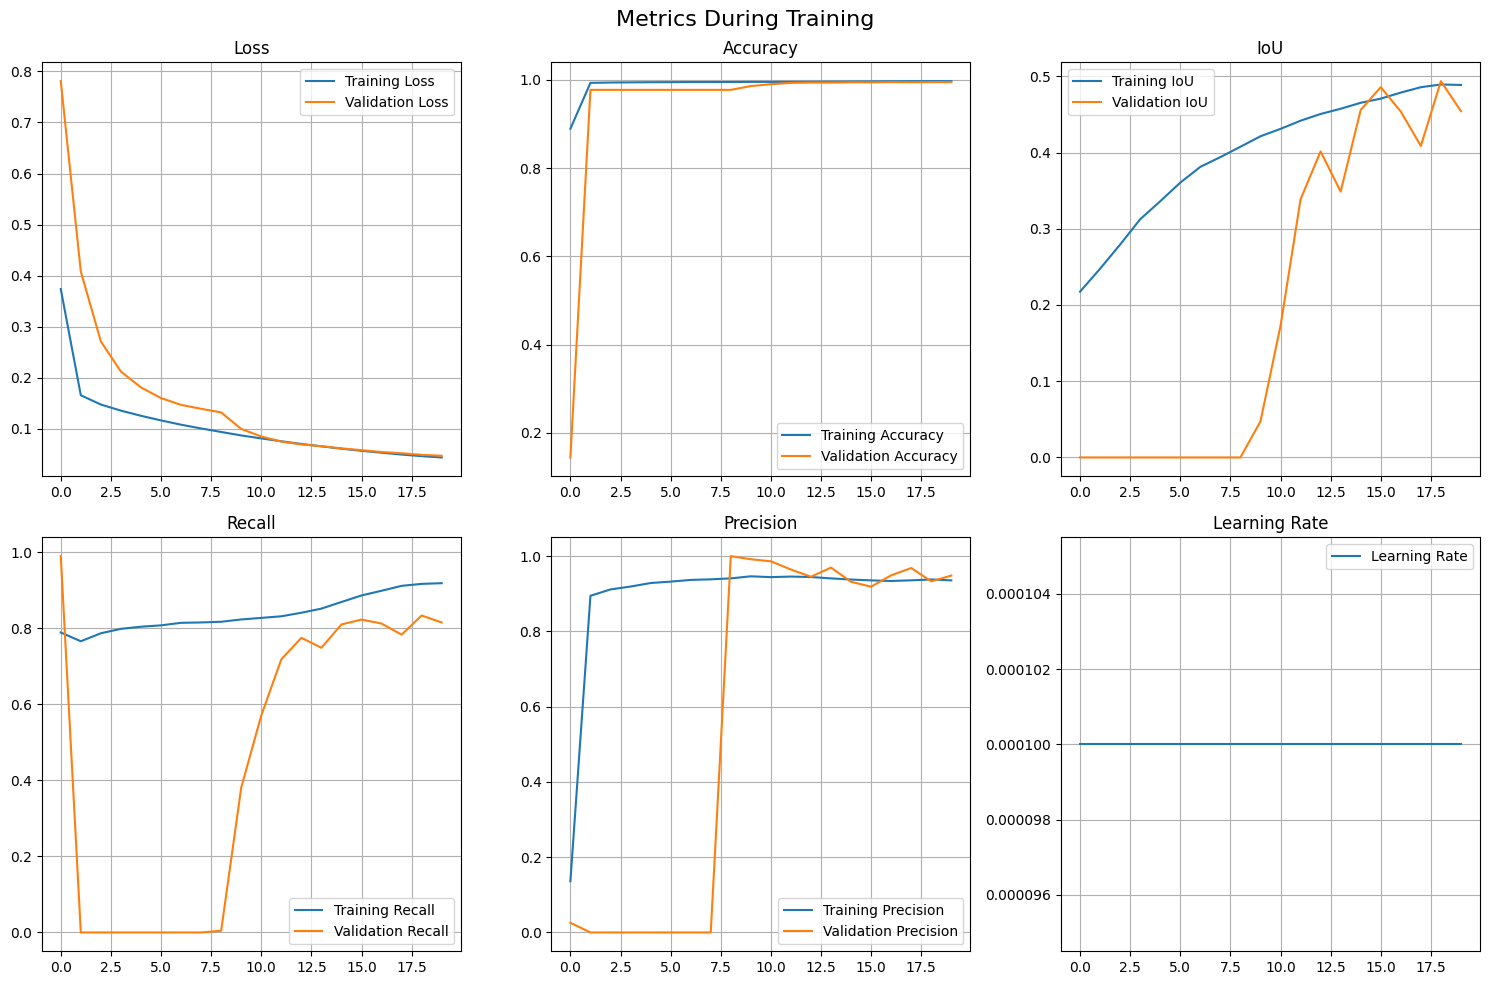

In [26]:
metrics_df = plot_training_metrics()

In [ ]:
# Обработка первого видео
print("\n" + "="*50)
print("Обработка первого видео")
print("="*50)
video_path_1 = 'mouse_segmentation/ch8_20221229173446_out.mp4'
mask_video(video_path_1, 'first_test_video1.avi')


Обработка первого видео
Starting video processing: miceSegmentation/ch8_20221229173446_out.mp4
Processed 30 frames
Processed 60 frames
Processed 90 frames
Processed 120 frames
Processed 150 frames
Processed 180 frames
Processed 210 frames
Processed 240 frames
Processed 270 frames
Processed 300 frames
Processed 330 frames
Processed 360 frames
Processed 390 frames
Processed 420 frames
Processed 450 frames
Processed 480 frames
Processed 510 frames
Processed 540 frames
Processed 570 frames
Processed 600 frames
Processed 630 frames
Processed 660 frames
Processed 690 frames
Processed 720 frames
Processed 750 frames
Processed 780 frames
Processed 810 frames
Processed 840 frames
Processed 870 frames
Processed 900 frames
Processed 930 frames
Processed 960 frames
Processed 990 frames
Processed 1020 frames
Processed 1050 frames
Processed 1080 frames
Processed 1110 frames
Processed 1140 frames
Processed 1170 frames
Processed 1200 frames
Processed 1230 frames
Processed 1260 frames
Processed 1290 f

Creating video: 100%|██████████| 20711/20711 [03:52<00:00, 89.23it/s] 

Video generated successfully: miceSegmentation/first_test_video1.avi


25.0

In [ ]:
print("\n" + "="*50)
print("Обработка второго видео")
print("="*50)
video_path_2 = 'mouse_segmentation/ch4_2023052318021_out.mp4'
mask_video(video_path_2, 'second_test_video1.avi')


Обработка второго видео
Starting video processing: miceSegmentation/ch4_2023052318021_out.mp4
Processed 30 frames
Processed 60 frames
Processed 90 frames
Processed 120 frames
Processed 150 frames
Processed 180 frames
Processed 210 frames
Processed 240 frames
Processed 270 frames
Processed 300 frames
Processed 330 frames
Processed 360 frames
Processed 390 frames
Processed 420 frames
Processed 450 frames
Processed 480 frames
Processed 510 frames
Processed 540 frames
Processed 570 frames
Processed 600 frames
Processed 630 frames
Processed 660 frames
Processed 690 frames
Processed 720 frames
Processed 750 frames
Processed 780 frames
Processed 810 frames
Processed 840 frames
Processed 870 frames
Processed 900 frames
Processed 930 frames
Processed 960 frames
Processed 990 frames
Processed 1020 frames
Processed 1050 frames
Processed 1080 frames
Processed 1110 frames
Processed 1140 frames
Processed 1170 frames
Processed 1200 frames
Processed 1230 frames
Processed 1260 frames
Processed 1290 fr

Creating video: 100%|██████████| 12904/12904 [05:01<00:00, 42.75it/s]

Video generated successfully: miceSegmentation/second_test_video1.avi


25.0

In [25]:
# image_path1 = 'miceSegmentation/ch1_2022122819344.bmp'
# check_image(image_path1)